In [1]:
import pandas as pd
from nltk.corpus import stopwords
import re
import string

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('coronavirustweets.csv', encoding = 'latin')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
df['Sentiment'] = df['Sentiment'].str.replace('Extremely Negative','Negative')

In [4]:
df['Sentiment'] = df['Sentiment'].str.replace('Extremely Positive','Positive')

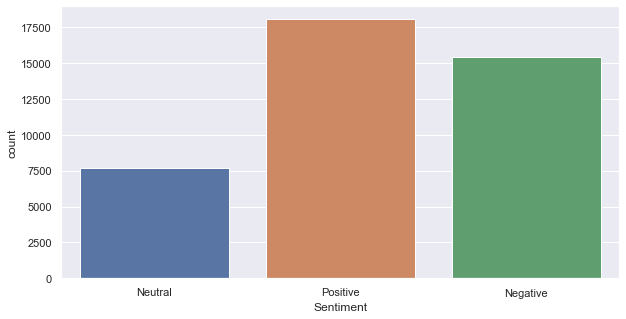

In [5]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(df['Sentiment'])

In [6]:
def clean_text(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [7]:
df.rename(columns={'OriginalTweet': 'text'}, inplace=True)
df.head()

,UserName,ScreenName,Location,TweetAt,text,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative


In [8]:
more_words=['say','going','like','U','u', 'http','https','url','today','hey','amp','...','apr','zip','pm']

def clean_data(df):
    df = df.dropna()
    df.isna().sum()
    df['text'] = df['text'].apply(lambda x: clean_text(x))
    df['text'] = df['text'].apply(lambda x: remove_emoji(x))
    df['text'] = df['text'].str.lower()
    stop_words=set(stopwords.words('english')) #nltk package
    stop_words.update(more_words)
    remove_words=lambda x: ' '.join([word for word in x.split() if word not in stop_words]) #.join is from package string
    df['text'] = df['text'].apply(remove_words)
    return df

In [9]:
df = clean_data(df)
df.head()

,UserName,ScreenName,Location,TweetAt,text,Sentiment
0,3799,48751,London,16-03-2020,menyrbie philgahan chrisitv,Neutral
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,Positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,news regionâs first confirmed case came sulli...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,cashier grocery store sharing insights prove c...,Positive


In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.2, stratify = df.Sentiment.values) 
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (26053, 6)
Test shape :  (6514, 6)


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.text.values)
X_test = vectorizer.transform(test.text.values)

y_train = train.Sentiment.values
y_test = test.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_test.shape : ", y_test.shape)

X_train.shape :  (26053, 42778)
X_test.shape :  (6514, 42778)
y_train.shape :  (26053,)
y_test.shape :  (6514,)


In [12]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Testing accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

Training accuracy Score    :  0.9800023029977354
Testing accuracy Score :  0.7783236106846791
              precision    recall  f1-score   support

    Negative       0.77      0.80      0.79      2315
     Neutral       0.70      0.65      0.67      1339
    Positive       0.82      0.82      0.82      2860

    accuracy                           0.78      6514
   macro avg       0.76      0.76      0.76      6514
weighted avg       0.78      0.78      0.78      6514



In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, random_state=100)
model_kfold = LogisticRegression()
results_kfold = cross_val_score(model_kfold, X_train, y_train, cv=kfold)
print("Training Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Training Accuracy: 77.63%


In [14]:
data = pd.read_csv("clean_data.csv")
data.head()

,user_name,user_location,date,text
0,Account2020,world,2021-04-25,bianca andreescu forced withdraw madrid open t...
1,┋𝔇𝔞𝔫𝔞’𝔰 𝔐𝔲𝔰𝔢┋,Earth,2021-04-25,farce last year recognizing handful talent cont…
2,اکو انق ملايو جاتي,Malaysia,2021-04-25,brazil records new coronavirus cases additiona...
3,इmranS,"Hyderabad, India",2021-04-25,akbarowaisimim one point praying iss wabah ka ...
4,Meraj Wali AFRIDI,Lucknow,2021-04-25,uaetonight stand solidarity india prominent la...


In [15]:
tweets = data['text']

In [16]:
tweets.head()

0    bianca andreescu forced withdraw madrid open t...
1     farce last year recognizing handful talent cont…
2    brazil records new coronavirus cases additiona...
3    akbarowaisimim one point praying iss wabah ka ...
4    uaetonight stand solidarity india prominent la...
Name: text, dtype: object

In [17]:
tweets = tweets.dropna()
df1 = tweets
df1=df1.drop_duplicates()
df1=df1.reset_index(drop=True)

In [18]:
df1.shape

(149988,)

In [19]:
from pickle import dump
# save the model
dump(logreg, open('model_lg.pkl', 'wb'))
# save the scaler
dump(vectorizer, open('scaler.pkl', 'wb'))

In [20]:
from pickle import load

# load the model
model = load(open('model_lg.pkl', 'rb'))
# load the scaler
scaler = load(open('scaler.pkl', 'rb'))
X_test_scaled = scaler.transform(df1)
yhat = model.predict(X_test_scaled)
#acc = accuracy_score(y_test, yhat)
#print('Test Accuracy:', acc)

In [21]:
yhat

array(['Positive', 'Neutral', 'Neutral', ..., 'Neutral', 'Neutral',
       'Neutral'], dtype=object)

In [22]:
type(yhat)

numpy.ndarray

In [23]:
tweet = pd.concat([df1,pd.DataFrame(yhat)],axis=1)

In [24]:
tweet.to_csv('result_lg.csv',index=False, header=["Tweet", "Sentiment_lg"])

In [25]:
t = pd.read_csv("result_lg.csv")
t.head()

,Tweet,Sentiment_lg
0,bianca andreescu forced withdraw madrid open t...,Positive
1,farce last year recognizing handful talent cont…,Neutral
2,brazil records new coronavirus cases additiona...,Neutral
3,akbarowaisimim one point praying iss wabah ka ...,Positive
4,uaetonight stand solidarity india prominent la...,Negative


Neutral     62263
Positive    49022
Negative    38703
Name: Sentiment_lg, dtype: int64


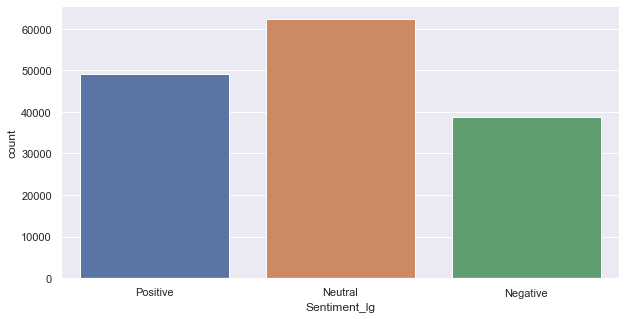

In [26]:
print(t['Sentiment_lg'].value_counts())
sns.countplot(t['Sentiment_lg'])